In [1]:
##Importing Neccesaary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.gridspec as gridspec
from scipy import stats
import matplotlib.style as style
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor,AdaBoostRegressor,ExtraTreesRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge,LinearRegression,Lasso,ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor

In [2]:
train=pd.read_csv('train_v9rqX0R.csv')
test=pd.read_csv('test_AbJTz2l.csv')

In [121]:

train['source']='train'
test['source']='test'
dataset = pd.concat([train, test],ignore_index=True)
print(train.shape, test.shape, dataset.shape)

(8523, 13) (5681, 12) (14204, 13)


In [122]:
dataset.describe()

,Item_MRP,Item_Outlet_Sales,Item_Visibility,Item_Weight,Outlet_Establishment_Year
count,14204.000000,8523.000000,14204.000000,11765.000000,14204.000000
mean,141.004977,2181.288914,0.065953,12.792854,1997.830681
std,62.086938,1706.499616,0.051459,4.652502,8.371664
min,31.290000,33.290000,0.000000,4.555000,1985.000000
25%,94.012000,834.247400,0.027036,8.710000,1987.000000
50%,142.247000,1794.331000,0.054021,12.600000,1999.000000
75%,185.855600,3101.296400,0.094037,16.750000,2004.000000
max,266.888400,13086.964800,0.328391,21.350000,2009.000000


# Missing Values

In [123]:
#Check missing values:
dataset.apply(lambda x: sum(x.isnull()))


Item_Fat_Content                0
Item_Identifier                 0
Item_MRP                        0
Item_Outlet_Sales            5681
Item_Type                       0
Item_Visibility                 0
Item_Weight                  2439
Outlet_Establishment_Year       0
Outlet_Identifier               0
Outlet_Location_Type            0
Outlet_Size                  4016
Outlet_Type                     0
source                          0
dtype: int64

# Imputing Missing Values

In [124]:
#Filling Missing vakues
dataset.Item_Outlet_Sales = dataset.Item_Outlet_Sales.fillna(dataset.Item_Outlet_Sales.mean())

In [125]:
dataset.Item_Weight = dataset.Item_Weight.fillna(dataset.Item_Weight.mean())

In [126]:
dataset.Outlet_Size = dataset.Outlet_Size.fillna('Medium')

In [127]:
dataset.apply(lambda x: sum(x.isnull()))

Item_Fat_Content             0
Item_Identifier              0
Item_MRP                     0
Item_Outlet_Sales            0
Item_Type                    0
Item_Visibility              0
Item_Weight                  0
Outlet_Establishment_Year    0
Outlet_Identifier            0
Outlet_Location_Type         0
Outlet_Size                  0
Outlet_Type                  0
source                       0
dtype: int64

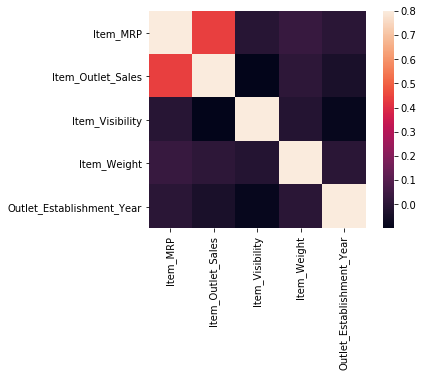

In [128]:
correlation=dataset.corr()
sns.heatmap(correlation,vmax=.8,square=True)

In [129]:
dataset.dtypes

Item_Fat_Content              object
Item_Identifier               object
Item_MRP                     float64
Item_Outlet_Sales            float64
Item_Type                     object
Item_Visibility              float64
Item_Weight                  float64
Outlet_Establishment_Year      int64
Outlet_Identifier             object
Outlet_Location_Type          object
Outlet_Size                   object
Outlet_Type                   object
source                        object
dtype: object

In [130]:
#Item type combine:
dataset['Item_Identifier'].value_counts()


NCO55    10
FDL40    10
FDO01    10
FDV20    10
FDD47    10
         ..
FDM52     7
FDM10     7
DRN11     7
NCW54     7
FDO33     7
Name: Item_Identifier, Length: 1559, dtype: int64

In [131]:
dataset['Item_Type_Combined'] = dataset['Item_Identifier'].apply(lambda x: x[0:2])
dataset['Item_Type_Combined'] = dataset['Item_Type_Combined'].map({'FD':'Food',
                                                             'NC':'Non-Consumable',
                                                             'DR':'Drinks'})
dataset['Item_Type_Combined'].value_counts()

Food              10201
Non-Consumable     2686
Drinks             1317
Name: Item_Type_Combined, dtype: int64

# Handling Categorical features

In [132]:
#Import library:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
le = LabelEncoder()
#New variable for outlet
dataset['Outlet'] = le.fit_transform(dataset['Outlet_Identifier'])
var_mod = ['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Item_Type_Combined','Outlet_Type','Outlet']
le = LabelEncoder()
for i in var_mod:
    dataset[i] = le.fit_transform(dataset[i])

In [133]:
#One Hot Coding:
dataset = pd.get_dummies(dataset, columns=['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Outlet_Type','Item_Type_Combined','Outlet'])

In [134]:
dataset.head()

,Item_Identifier,Item_MRP,Item_Outlet_Sales,Item_Type,Item_Visibility,Item_Weight,Outlet_Establishment_Year,Outlet_Identifier,source,Item_Fat_Content_0,...,Outlet_0,Outlet_1,Outlet_2,Outlet_3,Outlet_4,Outlet_5,Outlet_6,Outlet_7,Outlet_8,Outlet_9
0,FDA15,249.8092,3735.1380,Dairy,0.016047,9.30,1999,OUT049,train,0,...,0,0,0,0,0,0,0,0,0,1
1,DRC01,48.2692,443.4228,Soft Drinks,0.019278,5.92,2009,OUT018,train,0,...,0,0,0,1,0,0,0,0,0,0
2,FDN15,141.6180,2097.2700,Meat,0.016760,17.50,1999,OUT049,train,0,...,0,0,0,0,0,0,0,0,0,1
3,FDX07,182.0950,732.3800,Fruits and Vegetables,0.000000,19.20,1998,OUT010,train,0,...,1,0,0,0,0,0,0,0,0,0
4,NCD19,53.8614,994.7052,Household,0.000000,8.93,1987,OUT013,train,0,...,0,1,0,0,0,0,0,0,0,0


# Exporting Preprocessed data

In [135]:
import warnings
warnings.filterwarnings('ignore')
#Drop the columns which have been converted to different types:
dataset.drop(['Item_Type','Outlet_Establishment_Year'],axis=1,inplace=True)

#Divide into test and train:
train = dataset.loc[dataset['source']=="train"]
test = dataset.loc[dataset['source']=="test"]

#Drop unnecessary columns:
test.drop(['Item_Outlet_Sales','source'],axis=1,inplace=True)
train.drop(['source'],axis=1,inplace=True)

#Export files as modified versions:
train.to_csv("train_modified.csv",index=False)
test.to_csv("test_modified.csv",index=False)


In [136]:
train.head()

,Item_Identifier,Item_MRP,Item_Outlet_Sales,Item_Visibility,Item_Weight,Outlet_Identifier,Item_Fat_Content_0,Item_Fat_Content_1,Item_Fat_Content_2,Item_Fat_Content_3,...,Outlet_0,Outlet_1,Outlet_2,Outlet_3,Outlet_4,Outlet_5,Outlet_6,Outlet_7,Outlet_8,Outlet_9
0,FDA15,249.8092,3735.1380,0.016047,9.30,OUT049,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,DRC01,48.2692,443.4228,0.019278,5.92,OUT018,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
2,FDN15,141.6180,2097.2700,0.016760,17.50,OUT049,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,FDX07,182.0950,732.3800,0.000000,19.20,OUT010,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
4,NCD19,53.8614,994.7052,0.000000,8.93,OUT013,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0


In [137]:
test.head()

,Item_Identifier,Item_MRP,Item_Visibility,Item_Weight,Outlet_Identifier,Item_Fat_Content_0,Item_Fat_Content_1,Item_Fat_Content_2,Item_Fat_Content_3,Item_Fat_Content_4,...,Outlet_0,Outlet_1,Outlet_2,Outlet_3,Outlet_4,Outlet_5,Outlet_6,Outlet_7,Outlet_8,Outlet_9
8523,FDW58,107.8622,0.007565,20.750000,OUT049,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8524,FDW14,87.3198,0.038428,8.300000,OUT017,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
8525,NCN55,241.7538,0.099575,14.600000,OUT010,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
8526,FDQ58,155.0340,0.015388,7.315000,OUT017,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
8527,FDY38,234.2300,0.118599,12.792854,OUT027,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


# Model Building

In [3]:
# Reading modified preprocessed dta data
train2 = pd.read_csv("train_modified.csv")
test2 = pd.read_csv("test_modified.csv")

In [4]:
X_train = train2.drop(['Item_Outlet_Sales', 'Outlet_Identifier','Item_Identifier'], axis=1)
y_train= train2.Item_Outlet_Sales

In [5]:
X_test = test2.drop(['Outlet_Identifier','Item_Identifier'], axis=1)

In [6]:
X_train.head()

,Item_MRP,Item_Visibility,Item_Weight,Item_Fat_Content_0,Item_Fat_Content_1,Item_Fat_Content_2,Item_Fat_Content_3,Item_Fat_Content_4,Outlet_Location_Type_0,Outlet_Location_Type_1,...,Outlet_0,Outlet_1,Outlet_2,Outlet_3,Outlet_4,Outlet_5,Outlet_6,Outlet_7,Outlet_8,Outlet_9
0,249.8092,0.016047,9.30,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,48.2692,0.019278,5.92,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,141.6180,0.016760,17.50,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,182.0950,0.000000,19.20,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,53.8614,0.000000,8.93,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [7]:
X_test.head()

,Item_MRP,Item_Visibility,Item_Weight,Item_Fat_Content_0,Item_Fat_Content_1,Item_Fat_Content_2,Item_Fat_Content_3,Item_Fat_Content_4,Outlet_Location_Type_0,Outlet_Location_Type_1,...,Outlet_0,Outlet_1,Outlet_2,Outlet_3,Outlet_4,Outlet_5,Outlet_6,Outlet_7,Outlet_8,Outlet_9
0,107.8622,0.007565,20.750000,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,87.3198,0.038428,8.300000,0,0,0,0,1,0,1,...,0,0,1,0,0,0,0,0,0,0
2,241.7538,0.099575,14.600000,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,155.0340,0.015388,7.315000,0,1,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
4,234.2300,0.118599,12.792854,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [ ]:
# Feature Importance